# Import Libraries & Dependencies

In [1]:
#import libraries and dependencies
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
#Create connection to postgres database EmployeeSQL
load_dotenv()
my_env_var = os.getenv('DB_CONNECTION_STRING')
engine = create_engine(my_env_var)
connection = engine.connect()
connection

#connect engine
###note to group, update local host location and name of database to reflect what is on your system
# connection_string = "postgres:postgres@localhost:5432/final_project"
# engine = create_engine(f'postgresql://{connection_string}')

In [3]:
real_estateFinal_df = pd.read_sql('SELECT * FROM "real_estate_final"', engine)
pd.set_option('display.max_columns', None)
real_estateFinal_df.sample(5)

index                       address         neighborhood    borough  \
2167    2166      1506 overing st, unit 1a  westchester village      bronx   
88        88        350 w 71st st, unit 3f      upper west side  manhattan   
3674    3673    825 morrison ave, unit 16m            soundview      bronx   
34111  34111         185 hall st, unit 116         clinton hill   brooklyn   
22384  22382  118-17 union tpke, unit 14ab         forest hills     queens   

       bed  bath  days_on_market compass_property_type  \
2167     1   1.0             137                 co-op   
88       2   2.0             123                 condo   
3674     0   1.0             105                 co-op   
34111    1   1.0              42                 co-op   
22384    3   2.0              77                 co-op   

       compass_property_type_int mls_property_subtype mls_property_type  \
2167                           2                    0             co-op   
88                             1                    0             condo   
3674                           2                    0             co-op   
34111                          2                    0             co-op   
22384                          2                    0             co-op   

       listed_price  sold_price   sold_date  zipcode      lat     long  \
2167       128999.0    120000.0  2020-06-30    10461  40.8476 -73.8360   
88        1775000.0   1710000.0  2020-01-31    10023  40.7769 -73.9801   
3674            0.0    200000.0  2020-07-23    10473  40.8115 -73.8595   
34111      480000.0    460000.0  2020-02-14    11205  40.6940 -73.9650   
22384      998000.0    950000.0  2020-03-13    11375  40.7246 -73.8458   

       year_built dom_ranges  dom_tier  dom_lowerbound  dom_iqr  \
2167         None    105-188         2               0        0   
88     2019-01-01    105-188         2               0        0   
3674   1962-01-01     55-105         1               0        1   
34111  1958-01-01        <55         0               1        0   
22384  1973-01-01     55-105         1               0        1   

       dom_upperbound  dom_extended  dom_outlier  walkable_false  \
2167                1             0            0               0   
88                  1             0            0               0   
3674                0             0            0             200   
34111               0             0            0               0   
22384               0             0            0               0   

       walkable_true  health_level_dead  health_level_fair  health_level_good  \
2167             227                256                447               4780   
88               104                 57                375               1756   
3674               0                133                453               3654   
34111            174                116                328               2129   
22384            875                317                981               5566   

       health_level_poor  ada_access_no  ada_access_yes  ada_access_partial  \
2167                 153              4               1                   0   
88                    72              2               2                   0   
3674                 129              0               0                   0   
34111                 67              0               0                   0   
22384                195              2               1                   0   

       type_is_active_cleanup_mild_threat  type_is_active_significant_threat  \
2167                                    3                                  0   
88                                      0                                  0   
3674                                    1                                  0   
34111                                   8                                  1   
22384                                   2                                  0   

       type_is_completed_clean  type_i

## Random Forest Classifier Model

This model will classify the property type based on all the features selected in the X value.

In [4]:
#assign X values (independent variable) from the Real Estate Final table for the model - cast all as int 
X = real_estateFinal_df[['zipcode', 'sold_price','bed', 'bath', 'days_on_market', 'dom_tier', 'dom_lowerbound', 'dom_iqr', 'dom_upperbound','dom_extended', 
            'dom_outlier', 'walkable_false', 'walkable_true', 'health_level_dead', 'health_level_fair', 'health_level_good',
            'health_level_poor', 'ada_access_no', 'ada_access_yes', 'ada_access_partial', 
            'type_is_active_cleanup_mild_threat','type_is_active_significant_threat','type_is_completed_clean',
            'type_is_maintain_continued_threat', 'type_is_potential_threat', 'type_is_felony', 'type_is_violation', 
            'type_is_misdemeanor', 'danger_level_is_high', 'danger_level_is_low', 'lunch_eligibity_high_false_elem',
            'lunch_eligibity_high_true_elem', 'type_is_top_25th_percentile_elem', 'type_is_50th_percentile_elem',
            'type_is_75th_percentile_elem', 'type_is_bottom_25th_percentile_elem', 'lunch_eligibity_high_false_middle',
            'lunch_eligibity_high_true_middle', 'type_is_top_25th_percentile_middle', 'type_is_50th_percentile_middle',
            'type_is_75th_percentile_middle', 'type_is_bottom_25th_percentile_middle', 'lunch_eligibity_high_false_high',
            'lunch_eligibity_high_true_high', 'type_is_top_25th_percentile_high', 'type_is_50th_percentile_high',
            'type_is_75th_percentile_high', 'type_is_bottom_25th_percentile_high']]

X.astype(int)

zipcode  sold_price  bed  bath  days_on_market  dom_tier  \
0        10011     1646000    1     2              75         1   
1        10023      799000    1     1              60         1   
2        10025      670000    1     1             122         2   
3        10011     2175000    2     3              72         1   
4        10024     2333000    2     2             134         2   
...        ...         ...  ...   ...             ...       ...   
37223    11235      230000    1     1             105         1   
37224    11235     2050000    7     5             105         1   
37225    11235      800000    8     1             105         1   
37226    11235      940000    8     4             105         1   
37227    11235      850000    2     2              32         0   

       dom_lowerbound  dom_iqr  dom_upperbound  dom_extended  dom_outlier  \
0                   0        1               0             0            0   
1                   0        1               0             0            0   
2                   0        0               1             0            0   
3                   0        1               0             0            0   
4                   0        0               1             0            0   
...               ...      ...             ...           ...          ...   
37223               0        1               0             0            0   
37224               0        1               0             0            0   
37225               0        1               0             0            0   
37226               0        1               0             0            0   
37227               1        0               0             0            0   

       walkable_false  walkable_true  health_level_dead  health_level_fair  \
0                   0             85                 94                195   
1                   0            104                 57                375   
2                   0             64                126                576   
3                   0             85                 94                195   
4                   0             67                 80                370   
...               ...            ...                ...                ...   
37223               1            467                394               1276   
37224               1            467                394               1276   
37225               1            467                394               1276   
37226               1            467                394               1276   
37227               1            467                394               1276   

       health_level_good  health_level_poor  ada_access_no  ada_access_yes  \
0                   1769                 76              5               2   
1                   1756                 72              2               2   
2                   2796                198              4               1   
3                   1769                 76              5               2   
4                   2763                 98              3               0   
...                  ...                ...            ...             ...   
37223               3228                259             11               1   
37224               3228                259             11               1   
37225               3228                259             11               1   
37226               3228                259             11               1   
37227               3228                259             11               1   

       ada_access_partial  type_is_active_cleanup_mild_threat  \
0                       0                                   1   
1                       0                                   0   
2                       0                                   1   
3                       0                                   1   
4                       0                                   0   
...          

In [5]:
#assign Y value (dependent variable) from the Real Estate Final table for the model
y = real_estateFinal_df[['compass_property_type']]
y.dtypes

compass_property_type    object
dtype: object

In [6]:
#Run test and train of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
#Run the Random Forest Classifier and then fit it to the x and y train data - also score the x and y test data
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features="log2", min_samples_split=3, min_samples_leaf=2)
rf = rf.fit(X_train, y_train.values.ravel())
rf.score(X_test, y_test)

0.8762221983453314

In [8]:
#show the importance of the x features
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.2272002730017783, 'sold_price'),
 (0.17355187331064453, 'bed'),
 (0.09169473124279985, 'bath'),
 (0.05514518473816878, 'days_on_market'),
 (0.03261131412222132, 'zipcode'),
 (0.029717386193310054, 'health_level_dead'),
 (0.02480177189555674, 'health_level_good'),
 (0.02467307022120609, 'walkable_true'),
 (0.02166587866176877, 'type_is_completed_clean'),
 (0.02035665185775699, 'type_is_misdemeanor'),
 (0.019280139869923916, 'type_is_active_cleanup_mild_threat'),
 (0.01837513734940911, 'health_level_poor'),
 (0.01661551975271171, 'health_level_fair'),
 (0.01499376144454424, 'danger_level_is_high'),
 (0.014692293165858685, 'danger_level_is_low'),
 (0.013845168778965735, 'type_is_felony'),
 (0.013561769317808595, 'type_is_violation'),
 (0.012186459169749399, 'dom_iqr'),
 (0.01134932015709387, 'dom_tier'),
 (0.011217800998060872, 'lunch_eligibity_high_false_elem'),
 (0.010440966685941503, 'walkable_false'),
 (0.01018766749060923, 'type_is_bottom_25th_percentile_elem'),
 (0.0097337145436

In [9]:
#make prediction from model
y_pred = rf.predict(X_test)

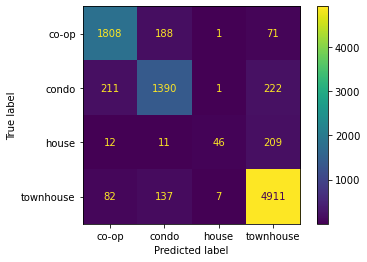

In [10]:
#evaluate the classification made by the model by declaring a confusion matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(rf,X_test,y_test)

In [11]:
#generate a classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       co-op       0.86      0.87      0.86      2068
       condo       0.81      0.76      0.78      1824
       house       0.84      0.17      0.28       278
   townhouse       0.91      0.96      0.93      5137

    accuracy                           0.88      9307
   macro avg       0.85      0.69      0.71      9307
weighted avg       0.87      0.88      0.87      9307



## Random Forest Regression

In [12]:
#assign X values from the Real Estate Final table for the model - cast all as int 
X1 = real_estateFinal_df[['zipcode','bed', 'bath', 'days_on_market', 'compass_property_type_int','listed_price',
            'dom_outlier', 'walkable_false', 'walkable_true', 'health_level_dead', 'health_level_fair', 'health_level_good',
            'health_level_poor', 'ada_access_no', 'ada_access_yes', 'ada_access_partial', 
            'type_is_active_cleanup_mild_threat','type_is_active_significant_threat','type_is_completed_clean',
            'type_is_maintain_continued_threat', 'type_is_potential_threat', 'type_is_felony', 'type_is_violation', 
            'type_is_misdemeanor', 'danger_level_is_high', 'danger_level_is_low', 'lunch_eligibity_high_false_elem',
            'lunch_eligibity_high_true_elem', 'type_is_top_25th_percentile_elem', 'type_is_50th_percentile_elem',
            'type_is_75th_percentile_elem', 'type_is_bottom_25th_percentile_elem', 'lunch_eligibity_high_false_middle',
            'lunch_eligibity_high_true_middle', 'type_is_top_25th_percentile_middle', 'type_is_50th_percentile_middle',
            'type_is_75th_percentile_middle', 'type_is_bottom_25th_percentile_middle', 'lunch_eligibity_high_false_high',
            'lunch_eligibity_high_true_high', 'type_is_top_25th_percentile_high', 'type_is_50th_percentile_high',
            'type_is_75th_percentile_high', 'type_is_bottom_25th_percentile_high']]

# X1 = real_estateFinal_df[['zipcode','bed', 'bath', 'days_on_market', 'health_level_dead','ada_access_yes', 
#             'type_is_completed_clean', 'compass_property_type_int']]


X1.astype(int)

#assign Y value (dependent variable) from the Real Estate Final table for the model
y1 = real_estateFinal_df[['sold_price']]

In [13]:
#Run test and train of the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state = 101)

#Run the Random Forest Regression and then fit it to the x and y train data
model = RandomForestRegressor(n_estimators = 300, max_depth = 200)
model.fit(X_train, y_train.values.ravel())

# filename = '../finalized_model.pkl'

# with open(filename, 'wb') as file:
#     pickle.dump(model, file)

RandomForestRegressor(max_depth=200, n_estimators=300)

In [14]:
#make prediction from model
y1_pred = model.predict(X_test)

#X_test
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result_regression = X_test
result_regression['sold_price'] = y_test
result_regression['y1_pred'] = y1_pred.tolist()
result_regression.sample(20)

<ipython-input-14-a91de3911ed3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_regression['sold_price'] = y_test
<ipython-input-14-a91de3911ed3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_regression['y1_pred'] = y1_pred.tolist()


zipcode  bed  bath  days_on_market  compass_property_type_int  \
25402    11369    1 1.000              33                          2   
36793    11203    3 3.500             105                          4   
15782    11420    3 1.500             190                          4   
22927    11356    6 5.000              72                          3   
13418    11234    0 1.000             105                          4   
17460    11429    3 2.500             138                          4   
21398    11360    4 3.000              25                          4   
35731    11234    3 1.500              48                          4   
3076     10471    2 1.000             127                          2   
32734    11206    1 1.000              76                          1   
10891    11374    0 1.000             105                          2   
7095     10307    3 2.250              36                          4   
22967    11423    1 1.000             105                          4   
31518    11694    1 1.000             105                          4   
34121    11226    2 1.500             167                          1   
7894     10312    2 2.000             105                          4   
28655    11223    5 2.000               9                          4   
27559    11354    1 1.000             105                          1   
6113     10312    4 4.250              34                          4   
605      10021    2 3.000              17                          2   

       listed_price  dom_outlier  walkable_false  walkable_true  \
25402    259000.000            0             243              0   
36793         0.000            0               0            254   
15782    445000.000            0               0            400   
22927   1399000.000            0             216              0   
13418         0.000            0             546              0   
17460    518000.000            0             264              0   
21398   1249000.000            0             303              0   
35731    682000.000            0             546              0   
3076     445000.000            0               0            206   
32734    679000.000            0               0            147   
10891         0.000            0               0            393   
7095     469900.000            0               0            192   
22967         0.000            0               0            139   
31518         0.000            0             206              0   
34121    720000.000            0               0            238   
7894          0.000            0             813              0   
28655         0.000            0               0            196   
27559         0.000            0               0            576   
6113     538000.000            0             813              0   
605     3750000.000            0               0             77   

       health_level_dead  health_level_fair  health_level_good  \
25402                165                396               2623   
36793                218                398               4406   
15782                294                666               4356   
22927                153                587               2249   
13418                415               1270               9227   
17460                181                301               2289   
21398                103                431               1882   
35731                415               1270               9227   
3076                  99                255               1505   
32734                217                674               3043   
10891                175                482               2300   
7095                 149                578               4548   
22967                184                330               2986   
31518                396                833               1958   
34121                169                460               3120   
7894                 830      

In [15]:
#score the y test data vs the predicted data
r2 = r2_score(y_test, y1_pred)
r2
print('R-squared scores:', round(r2, 3))

R-squared scores: 0.848


In [16]:
y_test, y1_pred

(       sold_price
 11228  340000.000
 9028   460000.000
 16967  800000.000
 30571  256470.000
 13051  372500.000
 ...           ...
 19278  497500.000
 22170  225000.000
 12773  507500.000
 6347   595000.000
 2125   380250.000
 
 [9307 rows x 1 columns],
 array([314976.71671741, 462971.01      , 778454.73      , ...,
        506882.33333333, 567700.36666667, 538732.46727778]))

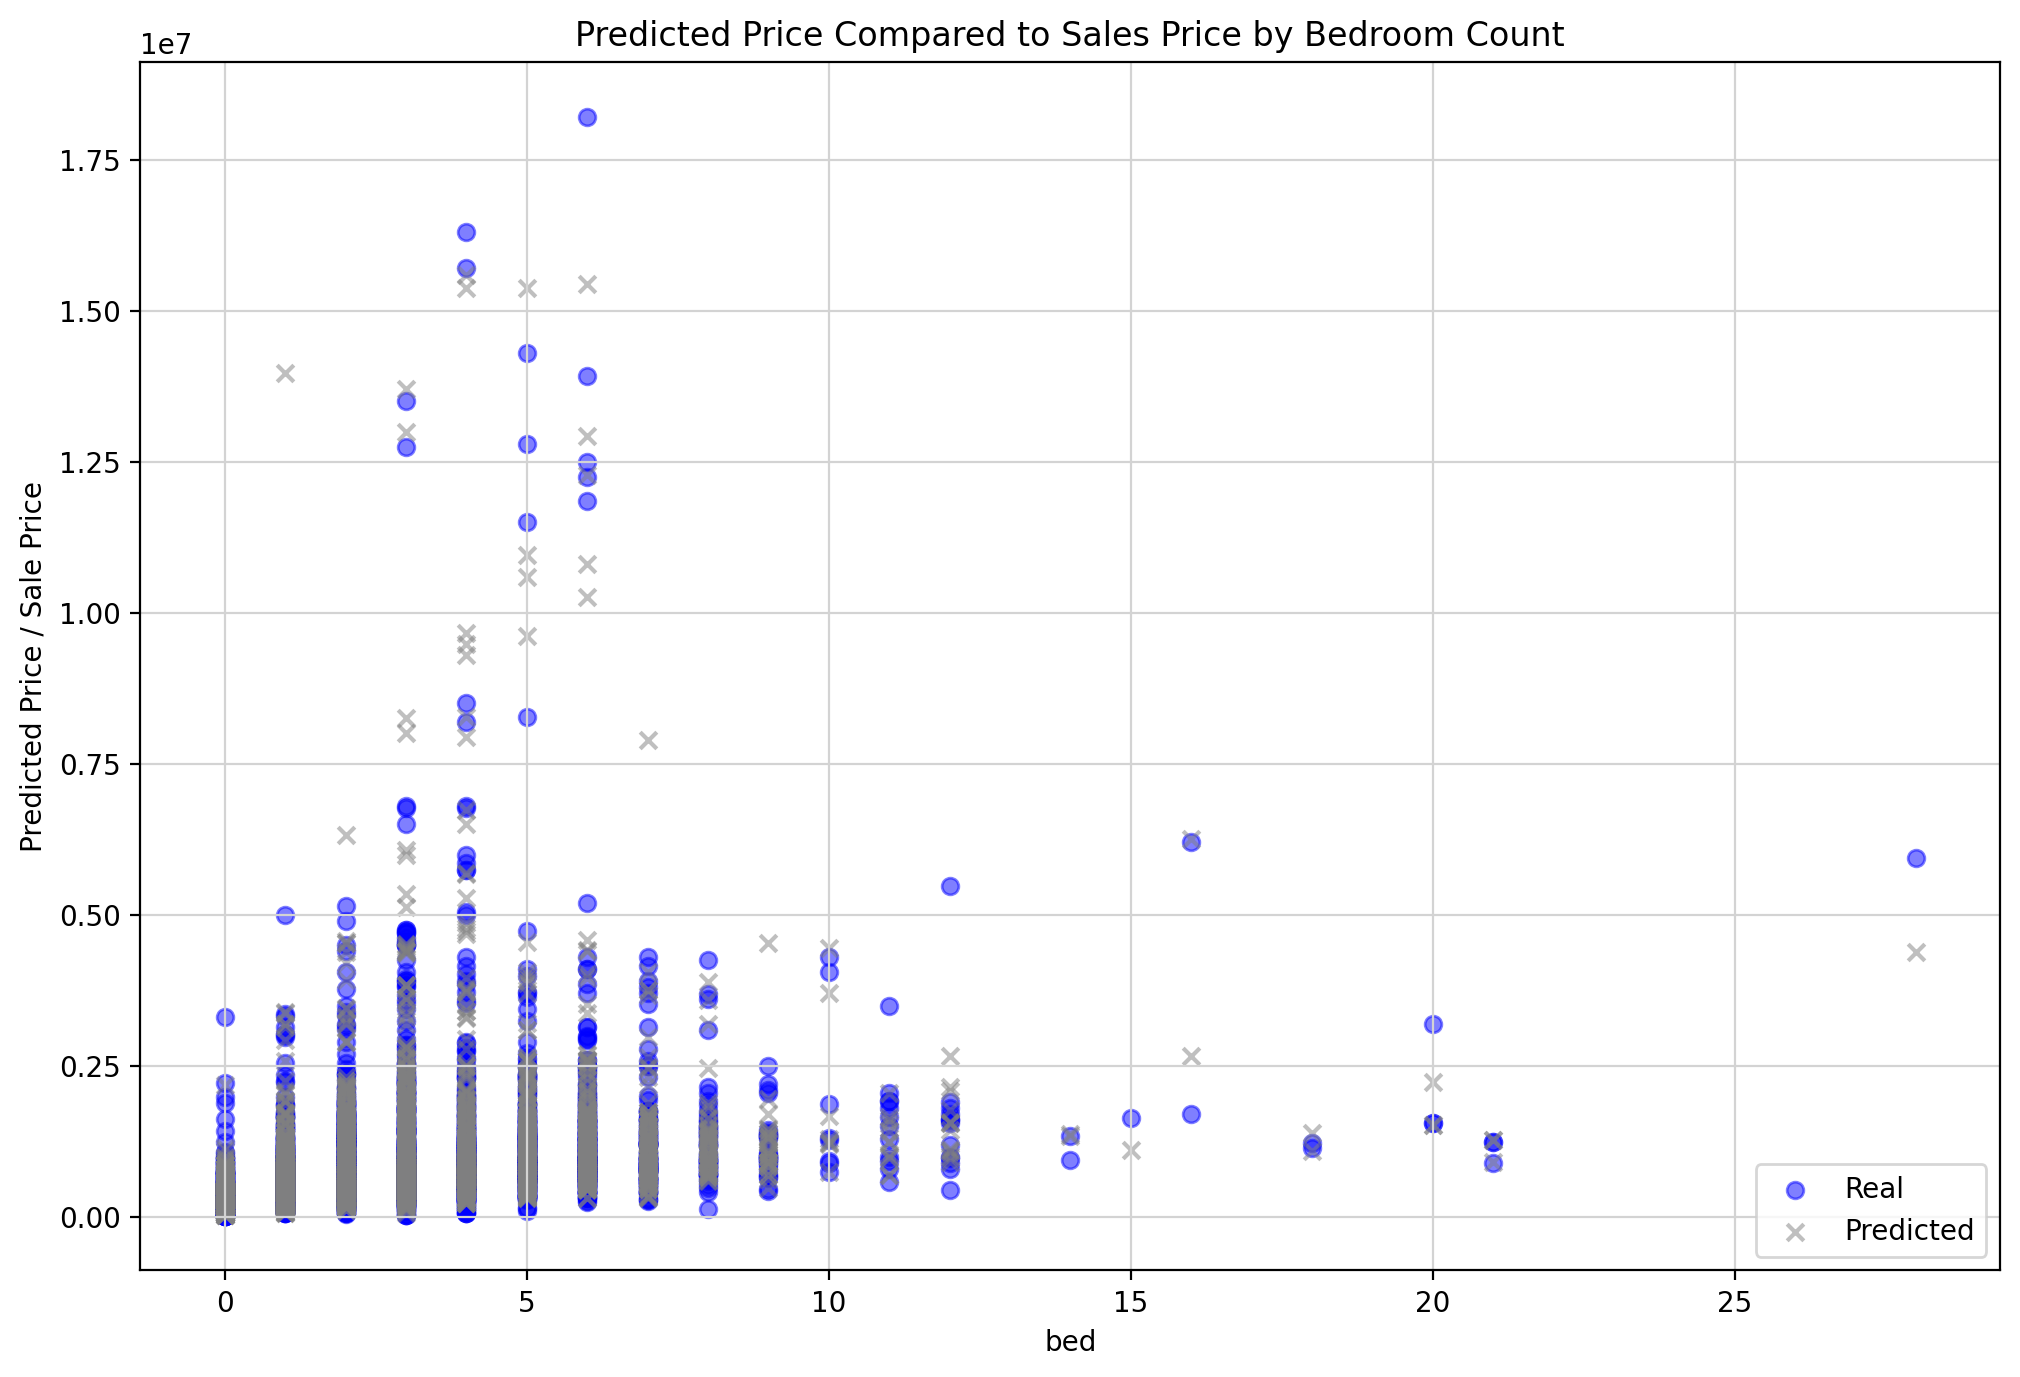

In [39]:
import matplotlib.ticker as ticker

# Define x axis
x_axis = X_test.bed

# fig, ax = plt.subplots()

# # Be sure to only pick integer tick locations.
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_locator(ticker.MaxNLocator(integer=True))

# yticks(ticks=y1, labels=None, **kwargs)[source]

# Build scatterplot
plt.figure(figsize=(12,8),dpi=200)
plt.scatter(x_axis, y_test, c = 'blue', alpha = 0.5, marker = 'o', label = 'Real')
plt.scatter(x_axis, y1_pred, c = 'gray', alpha = 0.5, marker = 'x', label = 'Predicted')
plt.xlabel('bed')
plt.ylabel('Predicted Price / Sale Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.title("Predicted Price Compared to Sales Price by Bedroom Count")
plt.savefig("Predicted Price Compared to Sales Price by Bedroom Count.png")
plt.show()

In [40]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
# # Mean absolute error (MAE)
# mae = mean_absolute_error(y_test.values.ravel(), y1_pred)

# # Mean squared error (MSE)
# mse = mean_squared_error(y_test.values.ravel(), y1_pred)

print('MAE:\t$%.2f' % mean_absolute_error(y_test.values.ravel(), y1_pred))
print('MSLE:\t%.5f' % mean_squared_log_error(y_test.values.ravel(), y1_pred))
print('MSE:\t%.5f' % mean_squared_error(y_test.values.ravel(), y1_pred))

MAE:	$81493.10
MSLE:	0.08157
MSE:	84547005969.20869


### This cell should only be run to perform tuning of the algorithm. One tool used to do this is GridSearchCV method which will obtain the best parameters for the algorithm. Takes forever to run.
from sklearn.model_selection import GridSearchCV

#Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [900, 1000, 1100]
}
gridforest = GridSearchCV(model, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

In [41]:
# Get features list
characteristics = X1.columns

In [42]:
# Get the variables importances, sort them, and print the result
importances = list(model.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: listed_price         Importance: 0.75
Variable: bath                 Importance: 0.05
Variable: zipcode              Importance: 0.04
Variable: bed                  Importance: 0.04
Variable: compass_property_type_int Importance: 0.03
Variable: days_on_market       Importance: 0.01
Variable: health_level_dead    Importance: 0.01
Variable: type_is_active_cleanup_mild_threat Importance: 0.01
Variable: dom_outlier          Importance: 0.0
Variable: walkable_false       Importance: 0.0
Variable: walkable_true        Importance: 0.0
Variable: health_level_fair    Importance: 0.0
Variable: health_level_good    Importance: 0.0
Variable: health_level_poor    Importance: 0.0
Variable: ada_access_no        Importance: 0.0
Variable: ada_access_yes       Importance: 0.0
Variable: ada_access_partial   Importance: 0.0
Variable: type_is_active_significant_threat Importance: 0.0
Variable: type_is_completed_clean Importance: 0.0
Variable: type_is_maintain_continued_threat Importance: 0.0
Vari

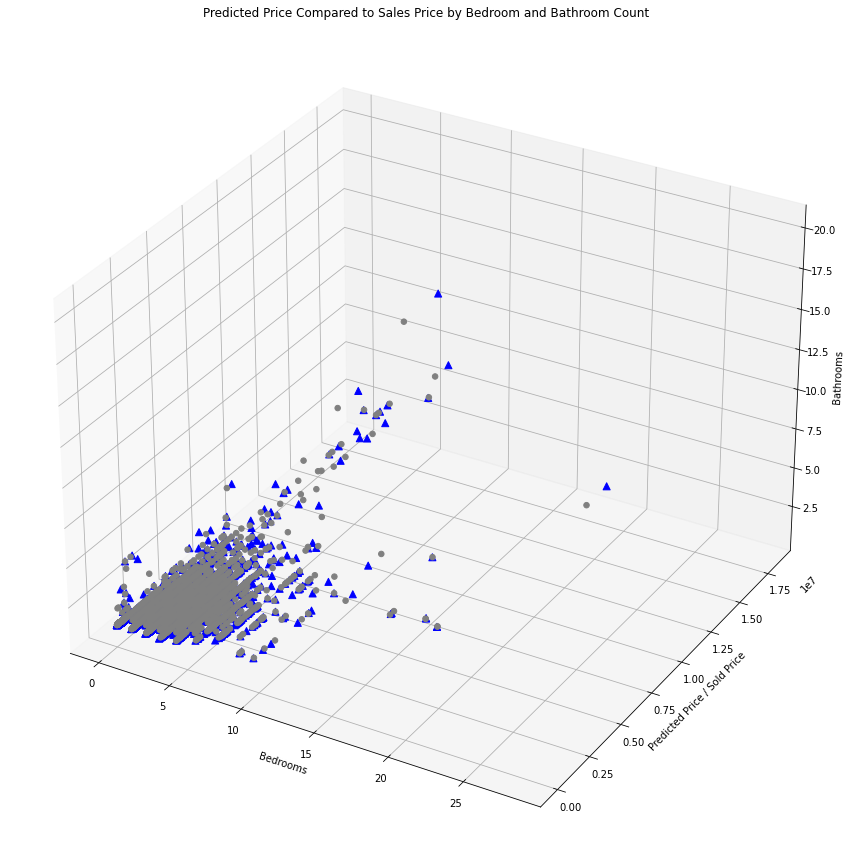

In [38]:
# %matplotlib qt
width = 15
height = 20
fig = plt.figure(figsize=(width, height))

ax = fig.add_subplot(111, projection='3d')

xs = result_regression[['bed']]
ys =result_regression[['y1_pred']]
zs =result_regression[['bath']]

xt = result_regression[['bed']]
yt =result_regression[['sold_price']]
zt =result_regression[['bath']]

ax.scatter(xs, ys, zs, marker='o', alpha=1, c='gray', s=30)
ax.scatter(xt, yt, zt, marker='^', alpha=1, c='blue', s=50)

ax.set_xlabel('Bedrooms')
ax.set_ylabel('Predicted Price / Sold Price')
ax.set_zlabel('Bathrooms')
plt.title("Predicted Price Compared to Sales Price by Bedroom and Bathroom Count")
plt.savefig("Predicted Price Compared to Sales Price by Bedroom and Bathroom Count.png")
plt.show()

In [45]:
import plotly.express as px

fig = px.scatter_3d(real_estateFinal_df, x='sold_price', y='compass_property_type', 
                    z='borough', color = 'borough', size_max=18, opacity=0.7, 
                    title = 'Sale Price by Borough & Property Type', labels = None)

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

In [36]:
import plotly.express as px

fig = px.scatter_3d(result_regression, x='y1_pred', y='sold_price', 
                    z='zipcode', color = 'zipcode', size_max=18, opacity=0.7,
                    title = 'Predicted Price vs. Sale Price by Zip Code')

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))